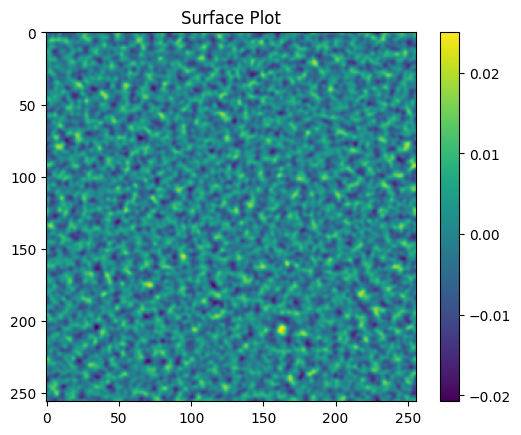

 Iter          Cost_f           Error
    0   -5.609338e+00    3.296393e+00
   50   -9.914176e+00    7.272961e-13
 Iter          Cost_f           Error
    0   -7.151177e+00    7.220822e-02
   40   -9.605534e+00    4.613731e-13
 Iter          Cost_f           Error
    0   -7.023090e+00    3.647338e-02
   38   -9.444453e+00    5.678055e-13
 Iter          Cost_f           Error
    0   -6.933230e+00    2.581889e-02
   37   -9.334746e+00    6.705524e-13
 Iter          Cost_f           Error
    0   -6.864320e+00    1.915848e-02
   38   -9.251283e+00    8.737809e-13
 Iter          Cost_f           Error
    0   -6.808515e+00    1.683002e-02
   37   -9.183758e+00    8.772801e-13
 Iter          Cost_f           Error
    0   -6.761413e+00    1.361646e-02
   37   -9.126972e+00    6.067185e-13
 Iter          Cost_f           Error
    0   -6.720598e+00    1.207320e-02
   37   -9.077864e+00    8.540950e-13
 Iter          Cost_f           Error
    0   -6.684654e+00    1.025713e-02
   37   -9.0

Execution time: 18.35644788108766
Fitted beta: 4.357368246452104e-06
Covariance matrix: [[8.86703451e-16 2.36406821e-09]
 [2.36406821e-09 6.34432677e-03]]
Contact area percentage: 0.05987548828125


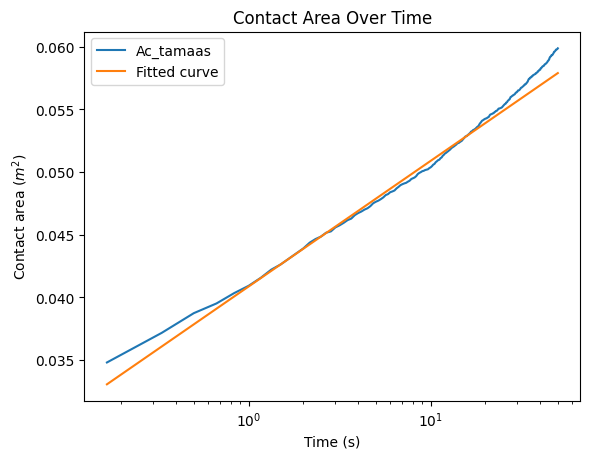

In [1]:
import tamaas as tm
import tamaas.utils
import matplotlib.pyplot as plt
import numpy as np
import time

# Parallel computation
tm.initialize(8)

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# Discretization
n = 256

# Generating surface
try:
    surface = np.load("surface.npy")
except FileNotFoundError:
    print("Error: 'surface.npy' not found. Make sure the file exists in the working directory.")
    surface = np.random.rand(n, n)  # For testing, replace with actual surface data

plt.imshow(surface)
plt.title("Surface Plot")
plt.colorbar()
plt.show()

# Domain size
L = 1.0

model = tm.Model(tm.model_type.basic_2d, [L, L], [n, n])
model.E = 3
model.nu = 0.5

shear_modulus = [3] * 50
characteristic_time = np.logspace(-3, 5, 50)

# Time
t0 = 0
t1 = 50
time_steps = 300
dt = (t1 - t0) / time_steps

# Const loading
W = 5e0

# Solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

solver.reset()

Ac_tamaas = []

# Solve for target pressure
p_target = W / (L**2)  # Average pressure

# Reset the solver to avoid history accumulation
solver.reset()

start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(tm.Statistics2D.contact(model.traction))

print(Ac_tamaas)

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)
np.save("Ac_tamaas.npy", Ac_tamaas)

# Curve fitting to get \beta
from scipy.optimize import curve_fit

Ac_tamaas = np.load("Ac_tamaas.npy")
origin_contact_area = np.load("Ac_tamaas.npy")

# Define the target function
def target_func(t, beta, t_star):
    return beta * (t - t_star) / np.min(characteristic_time)

# Extract the relevant data
x_data_1 = np.arange(t0, t1, dt)[:150] + dt
x_data_1 = np.log(x_data_1)
y_data_1 = origin_contact_area[:150]

# Perform the curve fitting
popt_1, pcov_1 = curve_fit(target_func, x_data_1, y_data_1, p0=(1, np.min(characteristic_time)))

# Extract the fitted parameters
beta_1_fit, t_star_1_fit = popt_1

# Print the fitted parameter
print("Fitted beta:", beta_1_fit)
print("Covariance matrix:", pcov_1)
print("Contact area percentage:", np.max(Ac_tamaas) / L**2)

# Plotting
plt.plot(np.arange(t0, t1, dt) + dt, Ac_tamaas, label="Ac_tamaas")
plt.plot(np.arange(t0, t1, dt) + dt, target_func(np.log(np.arange(t0, t1, dt) + dt), beta_1_fit, t_star_1_fit), label="Fitted curve")
plt.xlabel("Time (s)")
plt.ylabel("Contact area ($m^2$)")
plt.xscale("log")
plt.legend()
plt.title("Contact Area Over Time")
plt.show()
